#### **利用ogr开源库进行矢量数据处理**
**1. 投影转换**  
**2. 计算面要素的面积信息，添加面积字段/删除面积字段**  
**3. 获取面要素中心点，新建中心点图层**  
**4. 根据地理信息新建面要素**  


In [1]:
from osgeo import ogr


In [2]:
path_kunming_wgs84 = 'data/Section-2/kunming_wgs84.gpkg'


### 1. Re-project the vector to utm projection.
EPSG是European Petroleum Survey Group (欧洲石油调查小组)的缩写,该组织发布了一个坐标参照系统的数据集,数据集对全球收录到的坐标参照系统进行了编码。  
wgs84: 4326; 
wgs84+utm: 北半球：326+投影带（如32622）；南半球：327+投影带（32722）   
备注：gdal3.6.2对gpkg格式坐标系统写入支持不是很好。


In [3]:
#### Reprojection
## 1.读入待投影数据
path_kunming_utm48 = 'data/Section-4/kunming_utm48.gpkg'
utm_epsg = 32648
in_ds = ogr.Open(path_kunming_wgs84)
in_layer = in_ds.GetLayer(0)

## 2.创建新的空间参考
utm_spatialRef = ogr.osr.SpatialReference()
utm_spatialRef.ImportFromEPSG(utm_epsg)

## 3.创建写出数据及矢量图层
driver = ogr.GetDriverByName('GPKG')
out_ds = driver.CreateDataSource(path_kunming_utm48)
out_layer = out_ds.CreateLayer('kunming_utm48', geom_type = ogr.wkbPolygon, srs=utm_spatialRef)
# print(out_layer)

## 4. 创建投影转换对象，并进行投影转换
spatialRef = in_layer.GetSpatialRef()
coordinate_transform = ogr.osr.CoordinateTransformation(spatialRef, utm_spatialRef)
print(coordinate_transform)

## 在图层上创建属性字段
for i in range(in_layer.GetFeature(1).GetFieldCount()):
  field_defn = in_layer.GetFeature(1).GetFieldDefnRef(i)  
  out_layer.CreateField(field_defn)

## 获得要素定义(创建要素时需要)
FeaDefn = in_layer.GetLayerDefn()
### 遍历每个要素
for i in range(in_layer.GetFeatureCount()):
  in_fea = in_layer.GetFeature(i+1)
  in_geo = in_fea.geometry()            ## 获得原矢量要素的几何
  in_geo.Transform(coordinate_transform)
  out_fea = ogr.Feature(FeaDefn)        ## 定义输出要素
  out_fea.SetGeometry(in_geo)           ## 在输出要素中添加几何
  ### 遍历每个属性字段
  for j in range(FeaDefn.GetFieldCount()):
    field_value = in_fea.GetField(j)
    out_fea.SetField(j, field_value)    ## 在输出要素中添加输出属性
  out_layer.CreateFeature(out_fea)
ds = None
out_ds = None


<osgeo.osr.CoordinateTransformation; proxy of <Swig Object of type 'OSRCoordinateTransformationShadow *' at 0x0000025CC5BEBD80> >


#### 2. 添加/删除面积字段，并计算面积

In [4]:
### 删除字段
ds = ogr.Open(path_kunming_utm48, 1)  ## 0是只读，1是可写
layer = ds.GetLayer(0)
id_field = layer.GetFeature(1).GetFieldIndex('dt_adcode')
layer.DeleteField(id_field)   ## 删除字段，参数只能是索引
ds = None    ### 关闭数据源（重要）


In [5]:
### 新建字段并计算(以面积为例)
ds = ogr.Open(path_kunming_utm48, 1)  ## 0是只读，1是可写
layer = ds.GetLayer(0)
field_defn = ogr.FieldDefn('Area', ogr.OFTReal)   ## OFTReal：浮点型；OFTInteger: 整型
layer.CreateField(field_defn)       ## 创建新字段
area_districts, name_districts = [], []  ## 用于保存要素名和区名
### 遍历每一个要素
for i in range(layer.GetFeatureCount()):
  fea = layer.GetFeature(i+1)   ###
  fea_area = fea.geometry().Area()
  fea_area = fea_area/1000000      ### 单位：千米
  area_districts.append(fea_area)
  fea_name = fea.GetField('dt_name')
  name_districts.append(fea_name)
  print('Area is: ', fea_area)
  fea.SetField('Area(km2)', fea_area)   ## 对面积字段Field赋值
  layer.SetFeature(fea)  ## 更新特征
ds = None    ### 关闭数据源（重要）


Area is:  388.68132965333547
Area is:  864.295296736931
Area is:  638.33361729476
Area is:  887.0758120914002
Area is:  1866.1175875335928
Area is:  499.36396388766826
Area is:  1338.5644973111446
Area is:  994.1854960593394
Area is:  1914.092175416861
Area is:  1681.4133762503427
Area is:  828.4756858595103
Area is:  4227.121468713026
Area is:  3598.3429000372294
Area is:  1301.1314514651406


<BarContainer object of 14 artists>

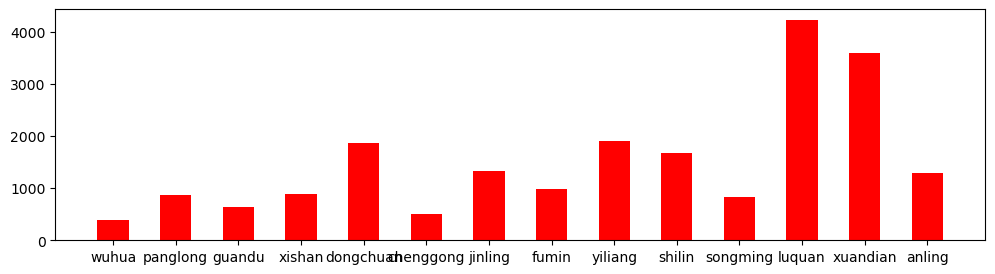

In [10]:
import matplotlib.pyplot as plt
### 柱状图
fig, ax = plt.subplots(1,1, figsize=(12,3))
ax.bar(name_districts, area_districts, width=0.5, color='red')


#### 3. 获取面要素中心点，新建中心点图层

In [11]:
path_kunming_districts_centroid = 'data/Section-4/kunming_utm48_centroid.gpkg'
in_ds = ogr.Open(path_kunming_utm48, 0)   ## 0是只读，1是可写
in_layer = in_ds.GetLayer(0); 
### 1. 创建新矢量文件
## 获取空间参考（创建图层需要）
in_SpatialRef = in_layer.GetSpatialRef()
driver = ogr.GetDriverByName('GPKG')
out_ds = driver.CreateDataSource(path_kunming_districts_centroid)
out_layer = out_ds.CreateLayer('kunming_utm48_centroid', geom_type=ogr.wkbPoint, srs=in_SpatialRef)  # create new layer in the shapefile 
field_defn = ogr.FieldDefn('Fid', ogr.OFTInteger)    ## 定义属性字段
out_layer.CreateField(field_defn)          ## 创建新字段
out_fea_defn = out_layer.GetLayerDefn()    ## 要素定义（等同于图层定义），创建要素需要
## 2. 遍历面要素并获取中心点
for i in range(in_layer.GetFeatureCount()):
  in_fea = in_layer.GetFeature(i+1)
  out_geo = in_fea.geometry().Centroid()   ## 获得中心点几何
  out_fea = ogr.Feature(out_fea_defn)      ## 创建空要素
  out_fea.SetGeometry(out_geo)             ## 设置要素几何
  out_fea.SetField('Fid', i+1)             ## 设置字段值
  out_layer.CreateFeature(out_fea)         ## 在图层中创建要素。
out_ds = None                              ## 关闭数据源
ds = None



#### 4. 新建几何及多要素图层
云大呈贡校园范围（(102.837, 24.832), (102.842, 24.836), (102.849, 24.836), (102.857, 24.835), (102.864, 24.828),(102.855, 24.826), (102.845, 24.821),(102.837, 24.832)）  
wkt(OGC well-known text)和wkb(OGC well-known binary)是OGC制定的空间数据的组织规范，wkt是以文本形式描述，wkb是以二进制形式描述。   
示例:  
Point: POINT (100 30)  
LineString: LINESTRING (120 10, 100 30, 90 20, 70 40)  
Polygon: POLYGON ((130 10, -140 40, 120 40, 110 20, 115 10))  

In [12]:
path_ynu_vector = 'data/Section-4/ynu_vec.gpkg'
### Create polygon by define wkt=
ynu_wkt = "POLYGON ((102.837 24.832, 102.842 24.836,102.849 24.836,102.857 24.835,102.864 24.828,102.855 24.826,102.845 24.821,102.837 24.832))"
geo_ynu = ogr.CreateGeometryFromWkt(ynu_wkt)
SpatialRef = ogr.osr.SpatialReference()   ## create spatial reference object
SpatialRef.ImportFromEPSG(4326)       ## set it to EPSG:4326
### 创建输出矢量数据
driver = ogr.GetDriverByName('GPKG')
ds_ynu = driver.CreateDataSource(path_ynu_vector)
layer_ynu = ds_ynu.CreateLayer('ynu_vec', srs=SpatialRef, geom_type=ogr.wkbPolygon)
field_defn = ogr.FieldDefn('Fid', ogr.OFTInteger)  ## 字段定义
layer_ynu.CreateField(field_defn)   ## 创建属性字段
fea_defn = layer_ynu.GetLayerDefn()
fea_ynu = ogr.Feature(fea_defn)     ## 定义要素
fea_ynu.SetField('Fid', 1)
fea_ynu.SetGeometry(geo_ynu)
layer_ynu.CreateFeature(fea_ynu)
ds_ynu = None

